In [1]:
# gen
from pathlib import Path

# for csv
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import numpy as np

# for audio
from struct import unpack
import soundfile as sf

# loop
from tqdm.notebook import tqdm_notebook

# data
import pickle as pkl

import matplotlib.pyplot as plt

In [2]:
# load data
path_to_data = Path("../WatchData/Final/")

participants = []
for child in path_to_data.iterdir():
    if "p" in child.name:
        print(child.name)
        participants.append(child.name)

p_53_Sarah
p_7_Vimal
p_45_Shiyi
p_43_Erin
p_23_Joe
p_55_Ellie
p_47_Kaylie
p_17_Rebecca
p_49_Alanna
p_51_Jaspreet
p_21_Rushil
p_19_Mayank
p_58_Anita


In [3]:
pid = "p_7_Vimal"
name = pid.split("_")[-1]    
path_to_participant = path_to_data / pid    
# get timestamps
timestamps = pd.read_csv(path_to_participant/"timestamps.csv", header=None,
                        names = ["PID", "Start", "Start_Main", "Stop_Main", 
                                 "Stop", "Context", "Activity", "TrialNo"])
display(timestamps)
assert len(timestamps) == 84, f"{pid} doesn't have enough timestamps, missing: {84 - len(timestamps)}"    
# num imus
num_imus = 2    
# get prefixes for left and right arm
prefixes = [f"{name}L/{name}L_All_", f"{name}R/{name}R_All_"]    
sensor_names = ["audio", "acce"]    
# paths to data
path_to_audio = [path_to_participant/f"{prefix}{sensor_names[0]}.raw" for prefix in prefixes]    
path_to_acc = [path_to_participant/f"{prefix}{sensor_names[1]}.csv" for prefix in prefixes]

,PID,Start,Start_Main,Stop_Main,Stop,Context,Activity,TrialNo
0,7,1625975375635,1625975377436,1625975394903,1625975397478,Bathroom,Brushing_hair,1
1,7,1625975527545,1625975534416,1625975551755,1625975559570,Bathroom,Washing_hands,1
2,7,1625975585389,1625975586447,1625975603514,1625975605247,Bathroom,Shaver_in_use,1
3,7,1625975656058,1625975658705,1625975676167,1625975677121,Bathroom,Hair_dryer_in_use,1
4,7,1625975729567,1625975731106,1625975749287,1625975757284,Bathroom,Toothbrushing,1
...,...,...,...,...,...,...,...,...
79,7,1625979558797,1625979559391,1625979575882,1625979577510,Kitchen,Wiping_with_rag,3
80,7,1625979585650,1625979593571,1625979603754,1625979608539,Kitchen,Microwave,3
81,7,1625979698722,1625979713987,1625979731551,1625979732538,All,Speech,1
82,7,1625979739930,1625979740845,1625979759103,1625979759937,All,Speech,2


In [4]:
# load acc data
acc_preprocessed = [pd.read_csv(path_to_acc[i], skiprows=1) for i in range(num_imus)] # i=0 is left

sensors_preprocessed = [acc_preprocessed]    
# set final timestamps
for sensor in sensors_preprocessed:
    for i in range(num_imus):
        t0_unix = sensor[i]["unixTimestamp"][0]
        t0_sensor = sensor[i]["sensorTimestamp"][0]
        # print(t0)
        sensor[i]["finalTimestamp"] = (sensor[i]["sensorTimestamp"] - t0_sensor)//(10**6) + t0_unix

sensors_preprocessed[0][0]

,unixTimestamp,sensorTimestamp,acce_x,acce_y,acce_z,finalTimestamp
0,1625975306570,893401900154983,-1.13088,2.43901,9.70994,1625975306570
1,1625975306574,893401919472640,-0.89626,2.07511,9.05396,1625975306589
2,1625975306578,893401938790244,0.02308,1.94583,9.03481,1625975306608
3,1625975306581,893401958107900,-0.13493,1.85006,8.99650,1625975306627
4,1625975306585,893401977425504,-0.14451,1.68248,8.58471,1625975306647
...,...,...,...,...,...,...
222620,1625979831590,897926752081488,2.28790,4.36387,8.29264,1625979831421
222621,1625979831612,897926772406176,2.59913,4.35429,8.60387,1625979831442
222622,1625979831633,897926792852947,1.80429,4.11967,8.15857,1625979831462
222623,1625979831651,897926813147166,1.98624,5.02464,7.76593,1625979831482


In [5]:
for sensor in sensors_preprocessed:
    print(sensor[0]["unixTimestamp"].iloc[-1] - sensor[1]["unixTimestamp"].iloc[-1])
    print(sensor[0]["finalTimestamp"].iloc[-1] - sensor[1]["finalTimestamp"].iloc[-1])    

4790
4466


In [29]:
audio_data = []
for imu in range(num_imus):
    # load audio
    binary = open(path_to_audio[imu], "rb")
    data = binary.read()
    audio_data.append(np.array(unpack('h'*(len(data)//2), data)))

    # plt.figure(figsize=(14, 5))
    # plt.plot(audio_data)
    # plt.show()

In [30]:
# add timestamps to audio_data
sr = 16000
audio_dfs = []
for imu in range(num_imus):
    t0 = sensors_preprocessed[0][imu]["unixTimestamp"][0] # sensors_preprocessed[0] is the acc
    t_end = sensors_preprocessed[0][imu]["finalTimestamp"].iloc[-1] 
    audio_df = pd.DataFrame(audio_data[imu], columns=["raw"])
    audio_df["finalTimestamp"] = t0 + 1000*audio_df.index//sr
    audio_dfs.append(audio_df)
    display(audio_df)

,raw,finalTimestamp
0,0,1625975306570
1,0,1625975306570
2,0,1625975306570
3,0,1625975306570
4,0,1625975306570
...,...,...
72399995,-1,1625979831569
72399996,-2,1625979831569
72399997,-3,1625979831569
72399998,-1,1625979831569


,raw,finalTimestamp
0,0,1625975282727
1,0,1625975282727
2,0,1625975282727
3,0,1625975282727
4,0,1625975282727
...,...,...
72703995,0,1625979826726
72703996,1,1625979826726
72703997,1,1625979826726
72703998,0,1625979826726


In [34]:
for audio_df in audio_dfs:
    audio_df[["Activity", "Context", "TrialNo", "PID"]] = None    

In [36]:
# loop through trials in timestamps
for i, timestamp_row in tqdm_notebook(timestamps.iterrows(), total=len(timestamps)):
    activity_start = timestamp_row["Start"]
    activity_start_main = timestamp_row["Start_Main"]
    activity_stop_main = timestamp_row["Stop_Main"]
    activity_stop = timestamp_row["Stop"]    
    # get trial data
    activity = timestamp_row["Activity"]
    context = timestamp_row["Context"]
    trial_no = timestamp_row["TrialNo"]
    PID = timestamp_row["PID"]    
    
    for imu in range(num_imus):
        # find all rows that in a dataset
        condition = ((audio_dfs[imu]["finalTimestamp"] <= activity_stop_main) &
                     (audio_dfs[imu]["finalTimestamp"] >= activity_start_main))
        # condition = ((sensor[i]["finalTimestamp"] <= activity_stop) &
        #              (sensor[i]["finalTimestamp"] >= activity_start))
        audio_dfs[imu].loc[condition, ["Activity", "Context", "TrialNo", "PID"]] = [activity, context, trial_no, PID]    

  0%|          | 0/84 [00:00<?, ?it/s]

In [37]:
# drop None rows
audio_dropna = []
for imu in range(num_imus):
    audio_dropna.append(audio_dfs[imu].dropna().reset_index(drop=True))    

In [38]:
display(audio_dropna[0])
display(audio_dropna[1])

,raw,finalTimestamp,Activity,Context,TrialNo,PID
0,-2,1625975377436,Brushing_hair,Bathroom,1,7
1,0,1625975377436,Brushing_hair,Bathroom,1,7
2,-1,1625975377436,Brushing_hair,Bathroom,1,7
3,-2,1625975377436,Brushing_hair,Bathroom,1,7
4,0,1625975377436,Brushing_hair,Bathroom,1,7
...,...,...,...,...,...,...
18650331,-3,1625979783227,Speech,All,3,7
18650332,-3,1625979783227,Speech,All,3,7
18650333,-2,1625979783227,Speech,All,3,7
18650334,-2,1625979783227,Speech,All,3,7


,raw,finalTimestamp,Activity,Context,TrialNo,PID
0,3,1625975377436,Brushing_hair,Bathroom,1,7
1,2,1625975377436,Brushing_hair,Bathroom,1,7
2,-3,1625975377436,Brushing_hair,Bathroom,1,7
3,-8,1625975377436,Brushing_hair,Bathroom,1,7
4,-14,1625975377436,Brushing_hair,Bathroom,1,7
...,...,...,...,...,...,...
18650331,0,1625979783227,Speech,All,3,7
18650332,1,1625979783227,Speech,All,3,7
18650333,1,1625979783227,Speech,All,3,7
18650334,0,1625979783227,Speech,All,3,7


In [39]:
import IPython.display as ipd

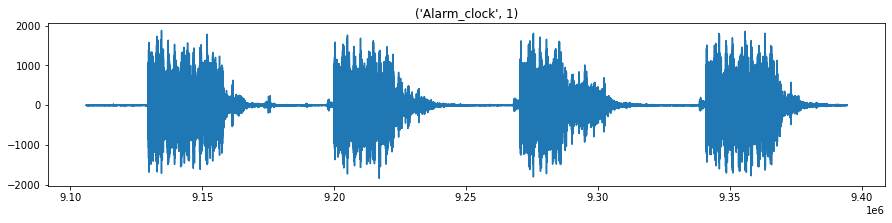

KeyboardInterrupt: 

In [40]:
# get a sample of each sound

c = 1
for name, group in audio_dropna[0][audio_dropna[1]["TrialNo"] == 1].groupby(["Activity", "TrialNo"]):

    display(ipd.Audio(group["raw"], rate=sr)) # load a NumPy array
    plt.figure(figsize=(15, 100))
    plt.subplot(28, 1, c)
    plt.plot(group["raw"])
    plt.title(name)
    plt.show()
    c+=1
    

In [44]:
1625979831569.93750 - 1625979831503

66.9375

In [ ]:
import librosa
import librosa.display

audioL.dtype

from datetime import timedelta

str(timedelta(seconds = len(audioL)/sr))

plt.figure(figsize=(14, 5))
sr = 16000
librosa.display.waveplot(audioL[:len(audioL)//2].astype(np.float32), sr=sr)

plt.figure(figsize=(14, 5))
sr = 16000
librosa.display.waveplot(audioR[:len(audioR)//2].astype(np.float32), sr=sr)

import IPython.display as ipd

# ipd.Audio(audioL, rate=sr) # load a NumPy array

# ipd.Audio(audioR, rate=sr)